In [23]:
import numpy as np
import cvxpy as cp

from case import *


class MRunResult:

    def __init__(self, diesel, renew, sot, value):
        self.diesel = diesel
        self.renew = renew
        self.sot = sot
        self.value = value
        

def runMOPF(case, genData, T=1, init_sot=0.1, cycle=True, robust=False, verb=False, solver=None, **kwargs):
    # load data from case
    n = case.N
    Y = case.adj
    Sij = case.smax
    v_lim = case.vlim
    lines = case.getLines()

    renew = genData.renew
    avgs = genData.avgs
    stds = genData.stds
    batteries = genData.batteries
    diesel = genData.diesel
    Load_data = genData.Load_data
    renew_lim = genData.renew_lim

    #Voltage matrix
    V = [cp.Variable((n,n), hermitian=True) for _ in range(T)]

    # power transfer variables
    pij = cp.Variable((len(lines), T))
    pji = cp.Variable((len(lines), T))
    qij = cp.Variable((len(lines), T))
    qji = cp.Variable((len(lines), T))

    # total generation variable
    pi_g = cp.Variable((n, T))
    qi_g = cp.Variable((n, T))
    renew_real = cp.Variable((len(renew), T))
    renew_react = cp.Variable((len(renew), T))

    

    diesel_real = cp.Variable((len(diesel), T))
    diesel_react = cp.Variable((len(diesel), T))
    sot = cp.Variable((n, T))
    pow_out = cp.Variable((n, T))
    pow_in = cp.Variable((n, T))

    max_out = 2
    max_in = 3
    max_charge = 100
    eta_in = 0.95
    eta_out = 0.95

    # Define constraints
    constraints=[]

    constraints += [pow_out >= 0, pow_in >= 0, sot >= 0]
    constraints += [pow_out <= max_out, pow_in <= max_in, sot <= max_charge]

    #Constraints on active and reactive generation (min-max)
    constraints += [diesel_real >= 0, diesel_real <= 50]
    constraints += [diesel_react >= -50, diesel_react <= 50]
    constraints += [renew_react >= -50, renew_react <= 50]
    for t in range(T):
        for i in range(renew_lim.shape[0]):
            constraints += [renew_real[i, t] <= renew_lim[i, t]]
    constraints += [renew_real >= 0]


    # Calculate the sum of all inbound power flows to each bus
    for t in range(T):

        if robust:
            max_gen = np.sum(avgs[:,t])-np.linalg.norm(stds[:,t])
            if max_gen > 0:
                constraints += [cp.sum(renew_real[:,t])<=max_gen]
            else:
                constraints += [cp,sum(renew_real[:,t])<=0]
        if cycle:
            constraints += [sot[:,-1] == init_sot]

        for i in range(n) :  
            psum = 0
            qsum = 0
            for line in range(len(lines)):
                start, end = lines[line]
                if start == i:
                    psum += pij[line, t]
                    qsum += qij[line, t]
                elif end == i:
                    psum += pji[line, t]
                    qsum += qji[line, t]

            # Sum pij = pi
            if t>0 and i in batteries:
                constraints += [sot[i, t] == sot[i, t-1] + (pow_in[i, t]*eta_in-pow_out[i, t]/eta_out)]
            else:
                constraints += [sot[i, t] == init_sot]
                constraints += [pow_in[i, t]==0, pow_out[i, t] == 0]
            gensum = 0
            rgensum = 0
            if i in batteries:
                gensum += -pow_in[i, t]+pow_out[i, t]
            if i in renew:
                gensum += renew_real[renew.index(i), t]
                rgensum += renew_react[renew.index(i), t]
            if i in diesel:
                gensum += diesel_real[diesel.index(i), t]
                rgensum += diesel_react[diesel.index(i), t]
            constraints += [psum == gensum-Load_data[i,0, t]]
            # Sum qij = qi 
            constraints += [qsum == rgensum-Load_data[i,1, t]]

            

            # Voltage limits
            constraints+=[cp.real(V[t][i,i])>= 0.95**2, cp.real(V[t][i,i]) <= 1.05**2]
            constraints += [cp.imag(V[t][i,i]) == 0]

        # Power flow equations (sparse representation)
        for line in range(len(lines)):
            i, j = lines[line]
                
            #Powerflow
            constraints+=[pij[line, t] + 1j*qij[line, t]==(V[t][i,i]-V[t][i,j])*np.conjugate(Y[i,j])] 
            constraints+=[pji[line, t] + 1j*qji[line, t]==(V[t][j,j]-V[t][j,i])*np.conjugate(Y[j,i])] 
            
            if not Sij[i,j] == 0:
            #Apparent power capacity S_bar
                constraints+=[cp.square(pij[line, t])+cp.square(qij[line, t])<=cp.square(Sij[i,j])]
                constraints+=[cp.square(pji[line, t])+cp.square(qji[line, t])<=cp.square(Sij[j,i])]
                
        for line in range(len(lines)):
            i, j = lines[line]
            constraints+=[cp.norm(cp.hstack([2*V[t][i,j],(V[t][i,i]-V[t][j,j])])) <= cp.real(V[t][i,i]+V[t][j,j])]
            constraints+=[cp.norm(cp.hstack([2*V[t][j,i],(V[t][j,j]-V[t][i,i])])) <= cp.real(V[t][j,j]+V[t][i,i])]

    # Define costs
    Costs = cp.sum(diesel_real)
    
    prob = cp.Problem(cp.Minimize(Costs), constraints)
    prob.solve(verbose=verb)
    try:
        ans = MRunResult(diesel_real.value, renew_real.value, sot.value, prob.value)
    except TypeError:
        return None
    return ans

In [8]:
case39 = loadCase("cases\\case39.json")

In [9]:
np.sum(case39.loadData[:,0])

62.542300000000004

In [10]:
np.sum(case39.genData[:,0] == 0)

29

In [85]:
diesel = [29]
batteries = [29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
renew = [30, 31, 32, 33, 34, 35, 36, 37, 38]

class gens:

    def __init__(self, diesel, batteries, renew, avgs, stds, Load_data, renew_lim):
        self.renew = renew
        self.diesel = diesel
        self.batteries = batteries
        self.avgs = avgs
        self.stds = stds
        self.Load_data = Load_data
        self.renew_lim = renew_lim


In [42]:
import os
import matplotlib.pyplot as plt
pv_directory   = 'PV Generation Data'
load_directory = 'Building Load Data'
wind_directory = 'Wind Generation Data'

# ALREADY GENERATED, takes 5 minutes to generate again so keep commented out
#dp.generate_json_from_pv_data(pv_directory) 
#dp.generate_json_from_bldg_data(load_directory) 
#dp.generate_json_from_wind_data(wind_directory) 

with open(os.path.join(pv_directory, 'pv_data.json'), 'r') as json_file:
    pv_dict = json.load(json_file)

for key in pv_dict.keys(): # get data from first key only (CAPTL_WF)
    solar_data = np.array(pv_dict[key])
    break

# for key, value in pv_dict.items():
    # print(key, value['0'])
    # break

with open(os.path.join(load_directory, 'real_data.json'), 'r') as json_file:
    real_load_dict = json.load(json_file)

with open(os.path.join(load_directory, 'reactive_data.json'), 'r') as json_file:
    reactive_load_dict = json.load(json_file)

with open(os.path.join(wind_directory, 'wind_data.json'), 'r') as json_file:
    wind_dict = json.load(json_file)

real_load_dict.keys()
real_load_dict['GeiselLibrary0']['0']
def toNDct(dict):
    ans = []
    for bld in dict:
        ls2 = []
        for day in dict[bld]:
            ls2.append(dict[bld][day])
        ans.append(ls2)
    return np.asarray(ans)

real_load = toNDct(real_load_dict)
react_load = toNDct(reactive_load_dict)
wind = toNDct(wind_dict)
solar = toNDct(pv_dict)


In [86]:
Load_data = np.zeros((39, 2, 24))
Load_data[:27,:] = np.stack((real_load[:,0,0::4], react_load[:,0,0::4]), axis=1)
renew_lim = (wind[:9,0,0::4]+solar[:9,0,0::4])*5
avgs = np.mean((wind[:9,:,0::4]+solar[:9,:,0::4])*4, axis=1)
stds = np.std((wind[:9,:,0::4]+solar[:9,:,0::4])*18, axis=1)

genDat = gens(diesel, batteries, renew, avgs, stds, Load_data, renew_lim)

In [52]:
avgs.shape

(9, 24)

In [53]:
np.sum(Load_data[:,1, 0])

12.516350694094886

In [87]:
#res = runMOPF(case39, genDat, T=24, init_sot=0)
res2 = runMOPF(case39, genDat, T=24, init_sot=0, robust=True)

In [28]:
np.sum(res.diesel)
res.diesel

array([[1.08659978e-12, 1.05907227e-11, 3.75832698e-12, 1.70352621e-12,
        1.13642429e-12, 1.11777254e-12, 1.11066711e-12, 1.08424381e-12,
        1.05937481e-12, 1.04272146e-12, 1.03006492e-12, 1.02384767e-12,
        1.02007292e-12, 1.01518793e-12, 1.01474384e-12, 1.01074704e-12,
        1.00519593e-12, 9.99866856e-13, 9.96092098e-13, 9.95203919e-13,
        9.95314942e-13, 1.00819353e-12, 1.02173825e-12, 1.08879572e-12]])

In [67]:
print(np.sum(res.diesel))
print(np.sum(res2.diesel))


3.791544530479339e-11
13.767345587859124


In [44]:
res.diesel

array([[1.08659978e-12, 1.05907227e-11, 3.75832698e-12, 1.70352621e-12,
        1.13642429e-12, 1.11777254e-12, 1.11066711e-12, 1.08424381e-12,
        1.05937481e-12, 1.04272146e-12, 1.03006492e-12, 1.02384767e-12,
        1.02007292e-12, 1.01518793e-12, 1.01474384e-12, 1.01074704e-12,
        1.00519593e-12, 9.99866856e-13, 9.96092098e-13, 9.95203919e-13,
        9.95314942e-13, 1.00819353e-12, 1.02173825e-12, 1.08879572e-12]])

In [75]:
np.sum(avgs, axis=0)-np.linalg.norm(stds, axis=0)

array([ 9.93786928,  9.78634245,  9.65294563,  9.93631338, 10.4937937 ,
       11.63412267, 13.44776169, 16.43996023, 20.77690097, 25.17020168,
       28.63228308, 30.454716  , 29.81778399, 27.29755142, 23.75931381,
       19.29845035, 14.29542197, 10.56103361,  9.11788944,  9.11907175,
        9.65546761, 10.25136993, 10.1143196 , 10.03649637])

TypeError: 'NoneType' object is not subscriptable

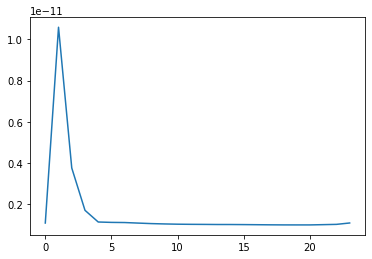

In [88]:
plt.plot(res.diesel[0])
plt.plot(res2.diesel[0])
plt.plot(np.sum(res2.renew, axis=0))
plt.plot(np.sum(Load_data[:,0,:], axis=0))

In [59]:
res.sot.shape

(39, 24)

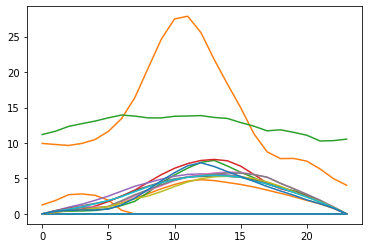

In [77]:
plt.plot(res.diesel[0])
plt.plot(res2.diesel[0])
[plt.plot(res.sot[i,:]) for i in range(39)]
plt.plot(np.sum(res2.renew, axis=0))
plt.plot(np.sum(Load_data[:,0,:], axis=0))

In [18]:
renew_lim

array([[0.00997009, 0.22087569, 0.1938243 , 0.87461781, 1.55541131,
        2.44359887, 3.05444532, 3.49207203, 5.42603029, 6.84147917,
        6.29776046, 6.25328703, 6.15220434, 4.51638772, 1.99864338,
        1.96933815, 2.64018585, 2.26876179, 3.16596649, 3.93693132,
        2.84585828, 2.19211617, 1.40762563, 1.35352284],
       [3.82150907, 4.41021788, 4.11827842, 4.18589675, 4.73596651,
        4.77245895, 4.76601911, 5.03135967, 6.42860124, 7.80941646,
        7.51659277, 6.2231083 , 5.4692219 , 4.7341101 , 4.06203153,
        2.50782741, 1.03683109, 0.82690401, 2.35268863, 3.92722979,
        4.57658044, 3.45229151, 3.51454331, 4.10700869],
       [3.57082333, 4.61869792, 4.92020901, 4.47747493, 4.68154216,
        4.68012993, 4.61869792, 4.7641576 , 4.26422551, 5.7169244 ,
        6.73995674, 6.64262292, 5.15860012, 4.51274736, 3.74656889,
        3.3828873 , 1.38475277, 1.02378776, 3.01511086, 3.98319446,
        4.60245728, 3.74029092, 3.67179777, 2.8329332 ],
       [1.513

In [19]:
res.sot

array([[-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
  

In [20]:
Load_data[1,:,:]

array([[0.49237637, 0.49226352, 0.49849627, 0.48913403, 0.49337623,
        0.49415565, 0.51326328, 0.53574447, 0.53470261, 0.53113486,
        0.53414888, 0.63149386, 0.77623002, 0.75821017, 0.76987786,
        0.75357432, 0.7513922 , 0.75420153, 0.7597034 , 0.74599399,
        0.73612788, 0.50296023, 0.49323321, 0.48795702],
       [0.75307989, 0.75774743, 0.74757947, 0.74505483, 0.74562743,
        0.73920738, 0.76247571, 0.77008433, 0.81182329, 0.81675111,
        0.80728588, 0.79207732, 0.76694371, 0.76417615, 0.76793275,
        0.75689721, 0.73359418, 0.75863236, 0.72957732, 0.70067844,
        0.69473556, 0.75221231, 0.74087313, 0.73925076]])

In [21]:
renew_real

NameError: name 'renew_real' is not defined